In [1]:
%matplotlib inline 
from matplotlib import pyplot as plt
from matplotlib_inline import backend_inline as bcil
import random
import torch
from torch.utils import data
from torch import nn

数据集生成

In [2]:
def synthetic_data(w, b, num_examples):  
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b # matmul() 对比 mm() 可以实现广播
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1)) # reshape中-1表示自动计算

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [3]:
features.shape, labels.shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

In [4]:
features[0], labels[0]

(tensor([0.2713, 0.3857]), tensor([3.4326]))

' numpy() 不放到梯度中 '

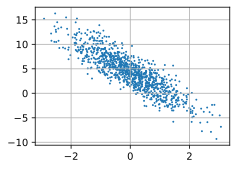

In [5]:
bcil.set_matplotlib_formats('svg')
plt.rcParams['figure.figsize'] = (3.5, 2.5)
plt.grid()
plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), s=1)
""" numpy() 不放到梯度中 """

In [6]:
# 实现小批量读取
def data_iter(batch_size, features, labels):
    num_examples = features.shape[0]
    indices = list(range(num_examples))
    random.shuffle(indices) # 将原列表顺序打乱
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)]) # 有可能超出索引范围： min()
        yield features[batch_indices], labels[batch_indices]
""" 
    batchsize 反直觉 
        有的时候越小越好？ 
"""
"""
    建模是不精确的，优化也是不精确的
    不太关心统计的最优解
    关心收敛的地方，希望收敛的地方平坦，范化性很好
"""
"""
    batch_size 不是整数倍
        1. 调整 batch_size
        2. 舍弃数据多余部分
        3. 从下一个 epoch 中借用数据
"""
"""
    NaN 是由于每一次梯度迭代存在除法
        有可能除 0 或者 inf
"""
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-1.3116,  0.3409],
        [-0.0581, -1.6152],
        [-0.2216, -0.1645],
        [ 0.9007,  1.4751],
        [-0.2969, -0.9631],
        [-1.0138,  0.6171],
        [ 0.8057,  0.6717],
        [-0.1871,  1.0036],
        [ 0.7250, -0.7546],
        [-1.2401,  0.2919]]) 
 tensor([[0.4373],
        [9.5798],
        [4.3136],
        [0.9968],
        [6.8787],
        [0.0615],
        [3.5198],
        [0.3987],
        [8.2080],
        [0.7342]])


参数初始化

In [7]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [8]:
# 定义模型
def linreg(X, w, b):
    return torch.matmul(X, w) + b

In [9]:
# 损失函数
def squred_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2

In [10]:
# 定义优化算法
def sgd(params, lr, batch_size):
    with torch.no_grad(): # 梯度优化不需要梯度计算
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_() # 手动归零

In [11]:
lr = 0.1
num_epochs = 10
net = linreg
loss = squred_loss
batch_size = 10

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        # l 的形状是 (batch_size, 1), 不是标量, 无法计算梯度
        # 使用 sum 累加损失
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train = loss(net(features, w, b), labels)
        print(f"epochs {epoch+1}, loss {float(train.mean()):.8f}")

epochs 1, loss 0.00010419
epochs 2, loss 0.00010347
epochs 3, loss 0.00010580
epochs 4, loss 0.00010213
epochs 5, loss 0.00010937
epochs 6, loss 0.00010414
epochs 7, loss 0.00010272
epochs 8, loss 0.00010309
epochs 9, loss 0.00010969
epochs 10, loss 0.00010258


In [12]:
""" 使用 Pytorch 提供的工具 """
features, labels = synthetic_data(true_w, true_b, 1000) # 生产初始化参数

In [13]:
def load_array(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays) # 当传递值为迭代器时, 使用*修饰
    return data.DataLoader(dataset, batch_size, shuffle = is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size, True)

next(iter(data_iter)) # 得到一个返回

[tensor([[ 0.0853,  0.4959],
         [ 1.0313,  0.8367],
         [-0.6157, -1.0470],
         [ 0.4173, -0.7461],
         [-0.1796, -0.4045],
         [ 0.1115,  1.3889],
         [ 0.1041,  0.4289],
         [-0.9726,  0.2552],
         [-0.7747, -0.1224],
         [-0.4387,  0.8183]]),
 tensor([[ 2.6906],
         [ 3.4241],
         [ 6.5027],
         [ 7.5795],
         [ 5.2188],
         [-0.3076],
         [ 2.9497],
         [ 1.3869],
         [ 3.0811],
         [ 0.5392]])]

In [14]:
""" Sequential : list of layers"""
net = nn.Sequential(nn.Linear(2, 1)) # 等价于全连接层

In [15]:
""" 初始化参数模型 """
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [16]:
loss = nn.MSELoss() # 均方误差

In [17]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

In [19]:
num_epochs = 10
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y) # Pytorch 默认进行了 sum() 运算
        trainer.zero_grad()
        l.backward()
        trainer.step()
    with torch.no_grad():
        l = loss(net(features), labels)
        print(f"epochs: {epoch + 1}, loss:{l:.8f}") # MSELoss没有 / 2

epochs: 1, loss:0.00010230
epochs: 2, loss:0.00010248
epochs: 3, loss:0.00010256
epochs: 4, loss:0.00010239
epochs: 5, loss:0.00010227
epochs: 6, loss:0.00010303
epochs: 7, loss:0.00010251
epochs: 8, loss:0.00010431
epochs: 9, loss:0.00010229
epochs: 10, loss:0.00010182
